In [3]:
from langchain_google_vertexai import ChatVertexAI
from langchain.prompts import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    ChatPromptTemplate,
    HumanMessagePromptTemplate
)

from pydantic import BaseModel, Field
from langchain.output_parsers import PydanticOutputParser
from langchain.output_parsers.json import SimpleJsonOutputParser

from typing import List, Tuple

import os
import json
import random

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
PATH = "..\\..\\src\\data\\komus\\dataset.json"

with open(PATH, "r", encoding="UTF-8") as file:
    data = json.load(file)

len(data)

83755

In [9]:
METRICS_CLASSIFY_DATASET_PATH = ".\\correct_categories\\approved_categories.json"

metrics_data = []

with open(METRICS_CLASSIFY_DATASET_PATH, "r", encoding="UTF-8") as file:
    for value in json.load(file).values():
        metrics_data += value["data"]



y_true = [item["answer"] for item in metrics_data]

len(metrics_data)

553

In [10]:
CATEGORIES_PATH = ".\\categories.txt"

with open(CATEGORIES_PATH, "r", encoding="UTF-8") as file:
    categories_array = file.read().splitlines()

categories_txt = "\n".join([f"{i}. {category}" for i, category in enumerate(categories_array, start=1)])
categories_txt

'1. Автозапчасти\n2. Аксессуары для мобильных устройств\n3. Здания и работы по возведению зданий\n4. Игры и игрушки\n5. Изделия готовые, не включенные в другие группировки\n6. Изделия из бумаги и картона\n7. Изделия из дерева, пробки, соломки и материалов для плетения\n8. Изделия из кожи\n9. Изделия из пластмасс\n10. Изделия металлические готовые прочие\n11. Изделия ножевые\n12. Изделия резиновые\n13. Изделия текстильные прочие\n14. Изделия ювелирные, бижутерия и подобные изделия\n15. Инструменты\n16. Инструменты и оборудование\n17. Инструменты музыкальные\n18. Канцелярские товары\n19. Карты и атласы\n20. Компьютеры и периферийное оборудование\n21. Культуры однолетние\n22. Материалы для строительства\n23. Материалы для строительства и ремонта\n24. Материалы лакокрасочные и аналогичные для нанесения покрытий\n25. Материалы растительные: растения живые; луковицы, клубнелуковицы и корневища; отводки и черенки; грибницы\n26. Материалы электромонтажные\n27. Мебель\n28. Металлоконструкции ст

# Utils

In [45]:
def create_model_prompts(system_prompt: str,
                         user_prompt: str) -> ChatPromptTemplate:
    system_prompt = SystemMessagePromptTemplate.from_template(system_prompt)
    user_prompt = HumanMessagePromptTemplate.from_template(user_prompt)
    chat_prompt = ChatPromptTemplate.from_messages(
        [system_prompt,
         user_prompt]
    )
    return chat_prompt

# Model

In [12]:
from langchain_openai import ChatOpenAI

T_PRO_CREDS = "..\\..\\secrets\\t-pro.json"

with open(T_PRO_CREDS) as file:
    model_params = json.load(file)

llm = ChatOpenAI(**model_params, temperature=0)

# Проведение классификации

## Подход 1
Классификация при помощи названия

### Zero-shot

Не работает

In [13]:
SYSTEM_PROMPT = """
Ты — эксперт в классификации товаров. Твоя задача — определить категорию товара на основе его названия. Используй следующие категории:

{categories}

Правила классификации:  
- Внимательно анализируй название товара.  
- Если название явно указывает на категорию, выбери соответствующую.  
- Если категория не очевидна, выбери наиболее подходящую из предложенных.  

Ответ предоставь в формате и не пиши ничего кроме:  
Категория: [НОМЕР КАТЕГОРИИ. НАЗВАНИЕ КАТЕГОРИИ]
""".strip()

USER_PROMPT = """
Товарная позиция: {problem_title}
""".strip()

prompt = create_model_prompts(SYSTEM_PROMPT, USER_PROMPT)

In [14]:
batch = [{
    "categories": categories_txt,
    "problem_title": product["title"]
} for product in metrics_data]

In [15]:
chain = prompt | llm

results = chain.batch(batch)

# print(*[[product["title"], ans.content] for product, ans in zip(metrics_data, results)], sep="\n")



Accuracy: 0.33


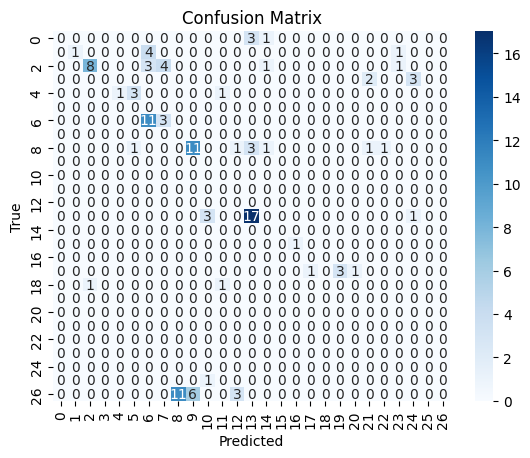

In [ ]:
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Вычисление матрицы ошибок
cm = confusion_matrix(y_true, y_pred)

# Визуализация матрицы ошибок
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### CoT

In [18]:
class ClassifyResponse(BaseModel):
    category: str = Field(..., description="""Ответ в формате: КАТЕГОРИЯ""")

parser = PydanticOutputParser(pydantic_object=ClassifyResponse)

SYSTEM_PROMPT = """
Ты — эксперт в классификации товаров. Твоя задача — определить категорию товара на основе его названия. Используй следующие категории:

{categories}

Правила классификации:  
- Внимательно анализируй название товара.  
- Если название явно указывает на категорию, выбери соответствующую.  
- Если категория не очевидна, выбери наиболее подходящую из предложенных.
- Если в названии товарной позиции описывается действие, то это должна быть категория "Услуги"
- Любое програмное обеспечение считается услугами

Подумай шаг за шагом.

Правила для формирования ответа:
1. **Рассуждение должно быть текстовым.**  
   - Рассуждения должны быть представлены в виде сплошного текста. Блоки кода в ходе рассуждения запрещены.
   - Все логические шаги, анализы и выводы должны быть изложены четко и последовательно.
2. **Финальный ответ должен быть представлен в виде JSON-объекта, заключённого в один блок кода.**  
   - Финальный ответ должен быть корректным JSON-объектом, который заключается в один блок кода (используя три обратных апострофа ```).
   - Внутри JSON-объекта не должно быть дополнительных объяснений или текстовых комментариев.
3. **Фраза "Окончательный ответ" должна предварять блок кода с JSON-объектом.**  
   - Перед блоком кода с JSON-объектом должна быть написана фраза **"Окончательный ответ:"** (без кавычек в самой фразе).  
   - Между фразой и блоком кода не должно быть пустых строк.

Формат ответа должен соответствовать этому: {format_instructions}
""".strip()

USER_PROMPT = """
Товарная позиция: {problem_title}
""".strip()

prompt = create_model_prompts(SYSTEM_PROMPT, USER_PROMPT)

In [19]:
batch = [{
    "categories": categories_txt,
    "problem_title": product["title"],
    "format_instructions": parser.get_format_instructions()
} for product in metrics_data]

In [20]:
chain = prompt | llm

results = chain.batch(batch)

# print(*[[product["title"], ans.content] for product, ans in zip(metrics_data, results)], sep="\n")

In [21]:
len([_ for _ in results if "Окончательный ответ:" in _.content])

553

In [22]:
for item in results:
    print(item.content)
    print()

Для классификации товара "Подставка для ноутбука/планшета Ugreen LP339 (40291_)" начнем с анализа его названия. 

1. Название содержит слова "подставка для ноутбука/планшета", что указывает на аксессуар, предназначенный для использования с мобильными устройствами.
2. Бренд "Ugreen" известен производством аксессуаров для электроники, в частности для мобильных устройств.
3. Номер модели "LP339" не дает дополнительной информации о категории, но контекст "ноутбука/планшета" ясен.

На основании этих данных можно сделать вывод, что данный товар относится к категории аксессуаров для мобильных устройств, так как он предназначен для улучшения удобства использования ноутбуков и планшетов.

Окончательный ответ:
```json
{"category": "Аксессуары для мобильных устройств"}
```

Для классификации товара "Клавиатура проводная ExeGate LY-331 (EX263905RUS)" начнем с анализа его названия. Название содержит слово "клавиатура", что является компонентом компьютерного оборудования. Проводная клавиатура относи

In [23]:
y_pred = [parser.invoke(item.content.split("Окончательный ответ:")[1]).category if parser.invoke(item.content.split("Окончательный ответ:")[1]).category in categories_array else "" for item in results]
y_pred

['Аксессуары для мобильных устройств',
 'Компьютеры и периферийное оборудование',
 'Компьютеры и периферийное оборудование',
 'Компьютеры и периферийное оборудование',
 'Аксессуары для мобильных устройств',
 'Компьютеры и периферийное оборудование',
 'Изделия резиновые',
 'Продукция для офиса',
 'Компьютеры и периферийное оборудование',
 'Компьютеры и периферийное оборудование',
 'Аксессуары для мобильных устройств',
 'Аксессуары для мобильных устройств',
 'Аксессуары для мобильных устройств',
 'Аксессуары для мобильных устройств',
 'Аксессуары для мобильных устройств',
 'Компьютеры и периферийное оборудование',
 'Аксессуары для мобильных устройств',
 'Аксессуары для мобильных устройств',
 'Компьютеры и периферийное оборудование',
 'Аксессуары для мобильных устройств',
 'Аксессуары для мобильных устройств',
 'Изделия из пластмасс',
 'Аксессуары для мобильных устройств',
 'Аксессуары для мобильных устройств',
 'Изделия готовые, не включенные в другие группировки',
 'Товары для дома',
 '

Accuracy: 0.65


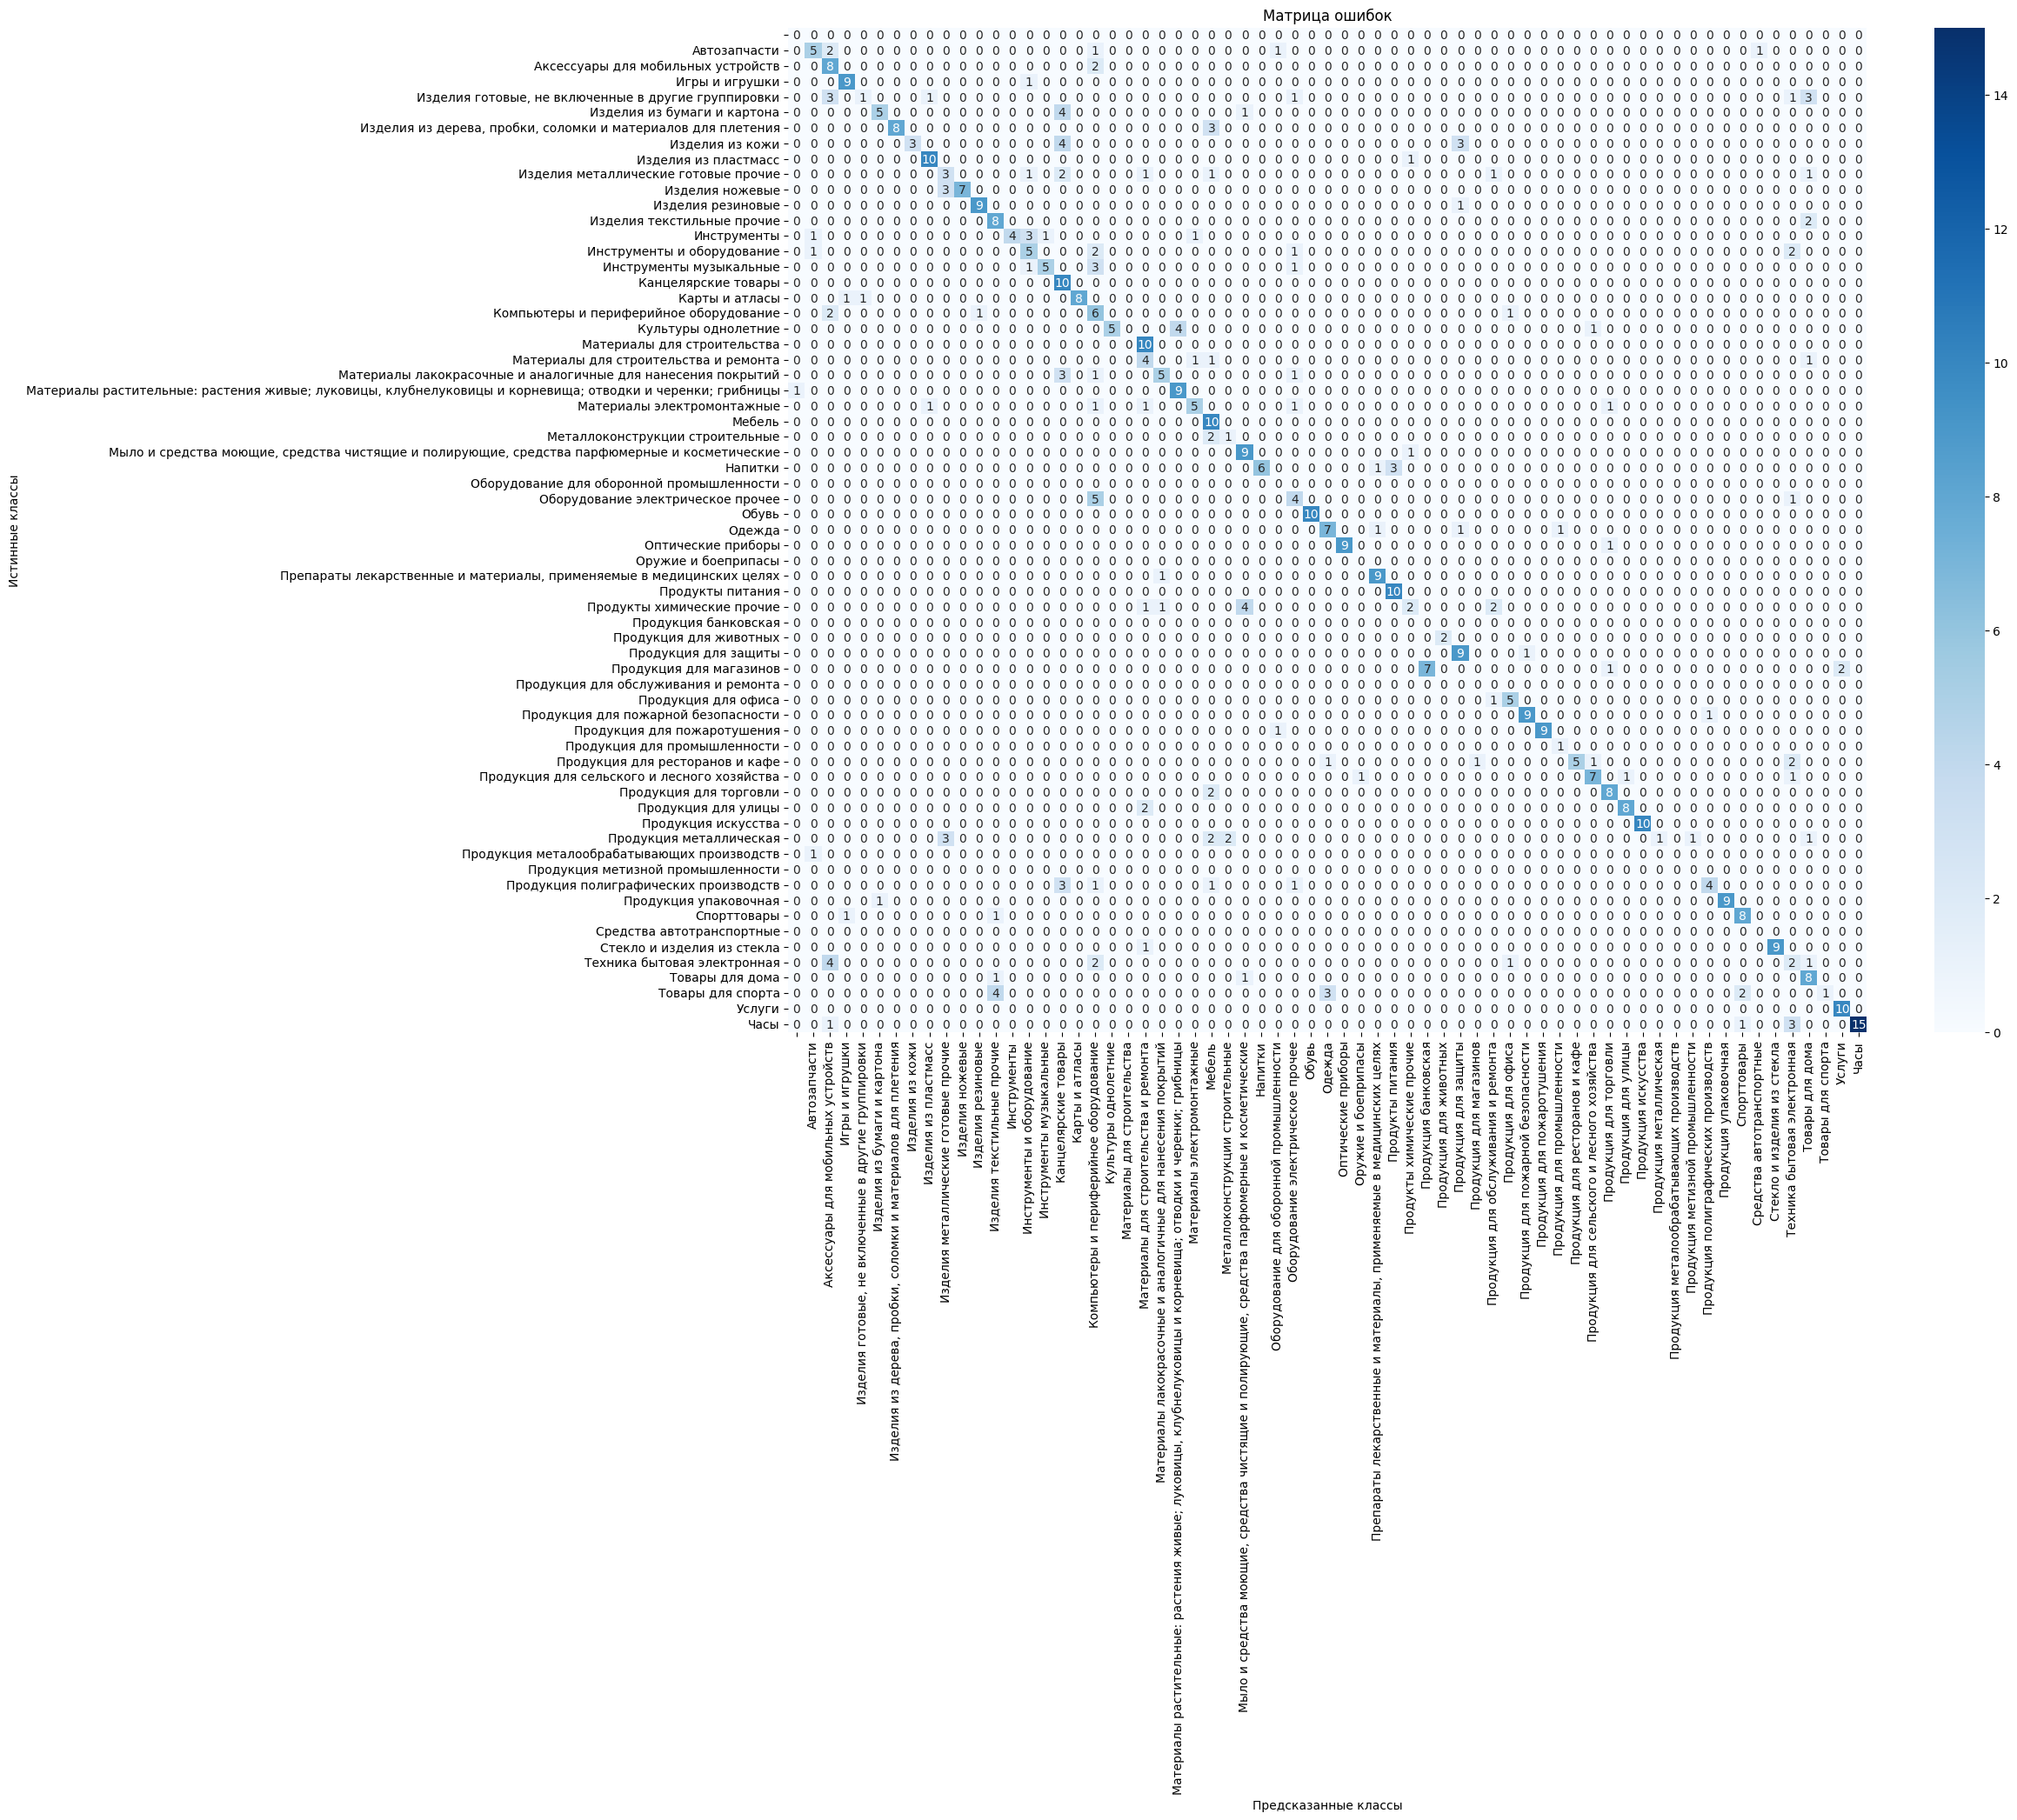

In [27]:
# Преобразование текстовых лейблов в числовые значения
label_encoder = LabelEncoder()

labels = set(y_true + y_pred)
label_encoder.fit_transform(list(labels))
y_true_encoded = label_encoder.transform(y_true)
y_pred_encoded = label_encoder.transform(y_pred)

cm = confusion_matrix(y_true_encoded, y_pred_encoded)

# Получение уникальных названий классов
class_names = label_encoder.classes_

print(f"Accuracy: {accuracy_score(y_true_encoded, y_pred_encoded):.2f}")

# Визуализация матрицы ошибок с названиями категорий
plt.figure(figsize=(20, 15))  # Устанавливаем размер графика
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Предсказанные классы")
plt.ylabel("Истинные классы")
plt.title("Матрица ошибок")
plt.show()

In [83]:
for item, true, pred in zip(metrics_data, y_true, y_pred):
    print(item["title"])
    print(true)
    print(pred)
    print()

Тетрадь школьная Комус Класс (№1 School) голубая А5 24 листа в клетку (10 штук в упаковке)
Канцелярские товары
Канцелярские товары

Смазка CET CET2828
Продукция для обслуживания и ремонта
Продукты химические прочие

Кулер для процессора DeepCool ICE EDGE Mini RET
Компьютеры и периферийное оборудование
Компьютеры и периферийное оборудование

Термистор CET CET531003
Продукция для обслуживания и ремонта
Оборудование электрическое прочее

Тетрадь школьная Альт Военный паттерн А5 24 листа в линейку (10 штук в упаковке)
Канцелярские товары
Канцелярские товары

Тумба приставная Metal System Style Б.ТП-1 (акация лорка, 412x720x750 мм)
Мебель
Мебель

Папка-планшет с зажимом Attache A4 пластиковая черная
Изделия из пластмасс
Канцелярские товары

Папка-конверт на молнии Attache А5 бесцветная 230 мкм (2 штуки в упаковке)
Изделия из пластмасс
Канцелярские товары

Уровень пузырьковый Matrix 3 глазка 1200 мм усиленный магнитный (34712)
Инструменты
Инструменты

Пуф Куба складной с ящиком для хранения 

## Подход 2

### Zero-shot

In [28]:
class ClassifyResponse(BaseModel):
    category: str = Field(..., description="""Ответ в формате: КАТЕГОРИЯ""")

parser = PydanticOutputParser(pydantic_object=ClassifyResponse)

SYSTEM_PROMPT = """
Ты — эксперт в классификации товаров. Твоя задача — определить категорию товара на основе его названия и вложенных категорий. Используй следующие категории:

{categories}

Правила классификации:  
- Внимательно анализируй название товара.  
- Если название явно указывает на категорию, выбери соответствующую.  
- Если категория не очевидна, выбери наиболее подходящую из предложенных.
- Если в названии товарной позиции описывается действие, то это должна быть категория "Услуги"
- ПО считается услугой


Правила для формирования ответа:
1. **Финальный ответ должен быть представлен в виде JSON-объекта, заключённого в один блок кода.**  
   - Финальный ответ должен быть корректным JSON-объектом, который заключается в один блок кода (используя три обратных апострофа ```).
   - Внутри JSON-объекта не должно быть дополнительных объяснений или текстовых комментариев.
2. **Фраза "Окончательный ответ" должна предварять блок кода с JSON-объектом.**  
   - Перед блоком кода с JSON-объектом должна быть написана фраза **"Окончательный ответ:"** (без кавычек в самой фразе).  
   - Между фразой и блоком кода не должно быть пустых строк.

Формат ответа должен соответствовать этому: {format_instructions}
""".strip()

USER_PROMPT = """
Товарная позиция: {problem_title}
Вложенные категории: {problem_categories}
""".strip()

prompt = create_model_prompts(SYSTEM_PROMPT, USER_PROMPT)

In [29]:
batch = [{
    "categories": categories_txt,
    "problem_title": product["title"],
    "problem_categories": product["categories"],
    "format_instructions": parser.get_format_instructions()
} for product in metrics_data]
chain = prompt | llm

results = chain.batch(batch)

# print(*[[product["title"], ans.content] for product, ans in zip(metrics_data, results)], sep="\n")

In [30]:
y_pred = [parser.invoke(item.content.split("Окончательный ответ:")[1]).category if parser.invoke(item.content.split("Окончательный ответ:")[1]).category in categories_array else ""  for item in results]
y_pred

['Аксессуары для мобильных устройств',
 'Аксессуары для мобильных устройств',
 'Аксессуары для мобильных устройств',
 'Аксессуары для мобильных устройств',
 'Аксессуары для мобильных устройств',
 'Игры и игрушки',
 'Изделия резиновые',
 'Компьютеры и периферийное оборудование',
 'Компьютеры и периферийное оборудование',
 'Компьютеры и периферийное оборудование',
 'Аксессуары для мобильных устройств',
 'Аксессуары для мобильных устройств',
 'Аксессуары для мобильных устройств',
 'Аксессуары для мобильных устройств',
 'Аксессуары для мобильных устройств',
 'Аксессуары для мобильных устройств',
 'Аксессуары для мобильных устройств',
 'Аксессуары для мобильных устройств',
 'Аксессуары для мобильных устройств',
 'Аксессуары для мобильных устройств',
 'Аксессуары для мобильных устройств',
 'Изделия из пластмасс',
 'Автозапчасти',
 'Автозапчасти',
 'Изделия готовые, не включенные в другие группировки',
 'Изделия готовые, не включенные в другие группировки',
 'Изделия готовые, не включенные в 

Accuracy: 0.89


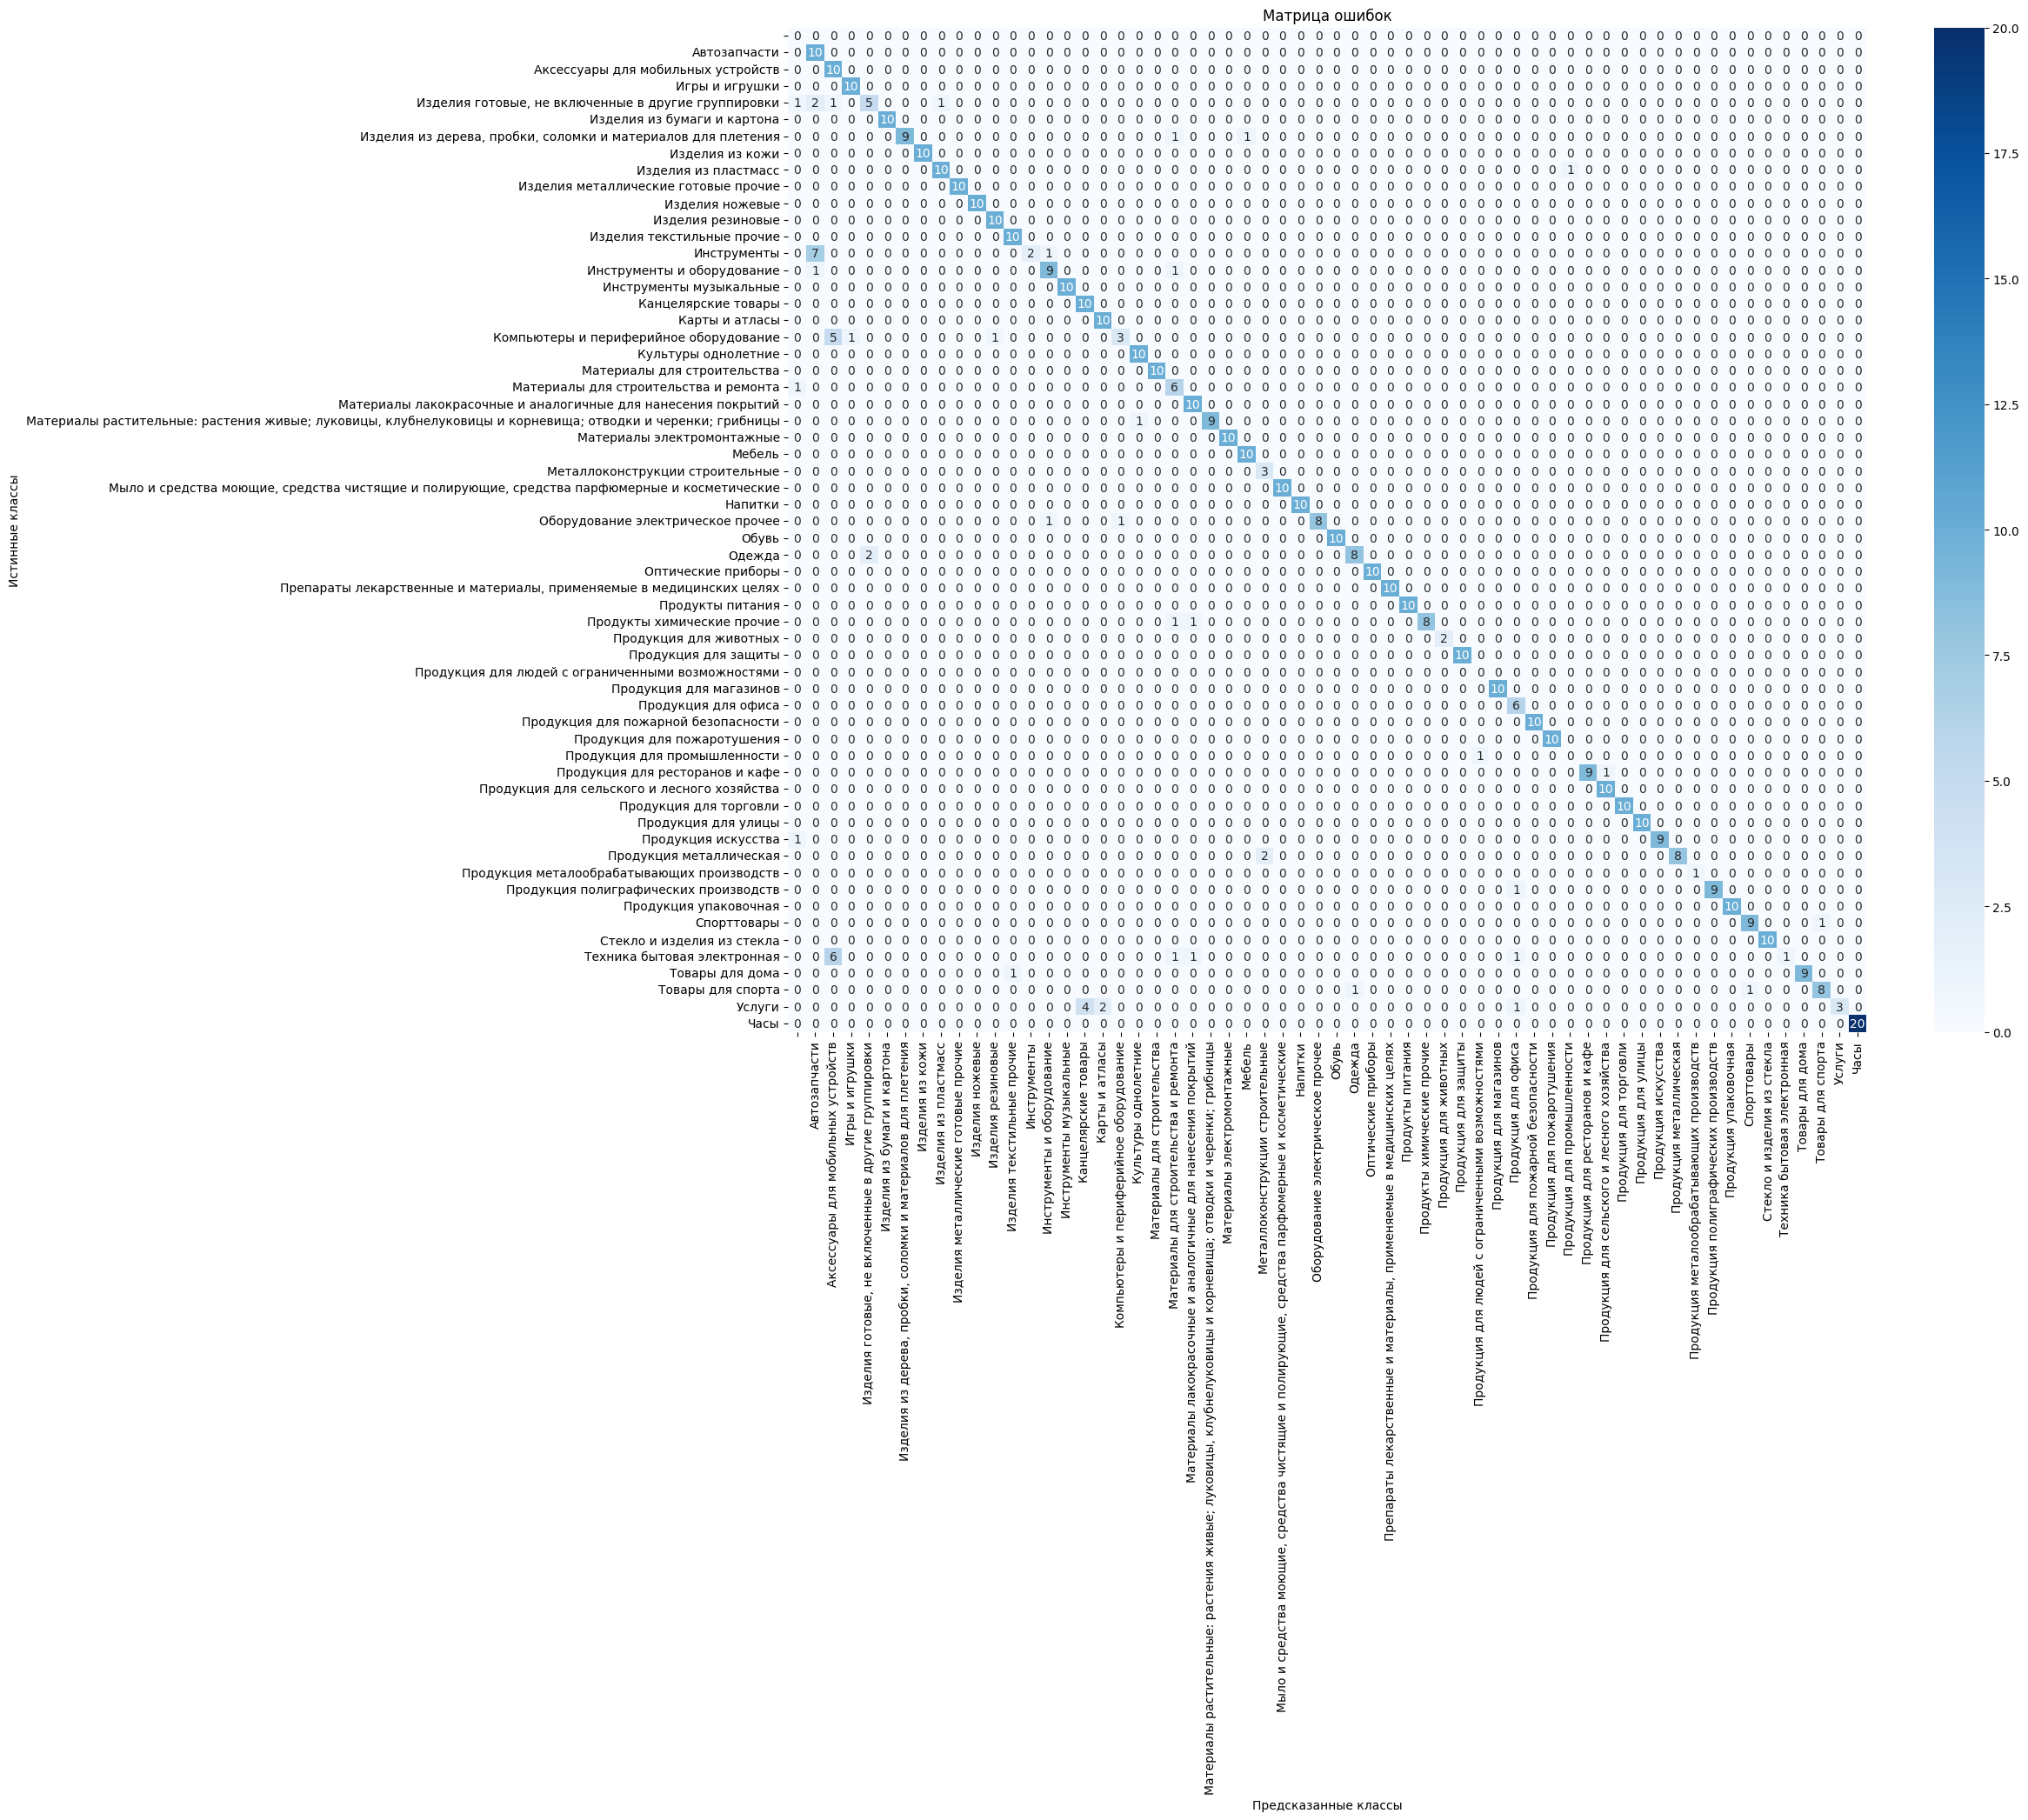

In [32]:
# Преобразование текстовых лейблов в числовые значения
label_encoder = LabelEncoder()

labels = set(y_true + y_pred)
label_encoder.fit_transform(list(labels))
y_true_encoded = label_encoder.transform(y_true)
y_pred_encoded = label_encoder.transform(y_pred)

cm = confusion_matrix(y_true_encoded, y_pred_encoded)

# Получение уникальных названий классов
class_names = label_encoder.classes_

print(f"Accuracy: {accuracy_score(y_true_encoded, y_pred_encoded):.2f}")

# Визуализация матрицы ошибок с названиями категорий
plt.figure(figsize=(20, 15))  # Устанавливаем размер графика
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Предсказанные классы")
plt.ylabel("Истинные классы")
plt.title("Матрица ошибок")
plt.show()

### CoT

In [43]:
class ClassifyResponse(BaseModel):
    category: str = Field(..., description="""Ответ в формате: КАТЕГОРИЯ""")

parser = PydanticOutputParser(pydantic_object=ClassifyResponse)

SYSTEM_PROMPT = """
Ты — эксперт в классификации товаров. Твоя задача — определить категорию товара на основе его названия и вложенных категорий. Используй следующие категории:

{categories}

Правила классификации:  
- Внимательно анализируй название товара.  
- Если название явно указывает на категорию, выбери соответствующую.  
- Если категория не очевидна, выбери наиболее подходящую из предложенных.
- Если в названии товарной позиции описывается действие, то это должна быть категория "Услуги"
- ПО считается услугой

Подумай шаг за шагом.

Правила для формирования ответа:
1. **Рассуждение должно быть текстовым.**  
   - Рассуждения должны быть представлены в виде сплошного текста. Блоки кода в ходе рассуждения запрещены.
   - Все логические шаги, анализы и выводы должны быть изложены четко и последовательно.
2. **Финальный ответ должен быть представлен в виде JSON-объекта, заключённого в один блок кода.**  
   - Финальный ответ должен быть корректным JSON-объектом, который заключается в один блок кода (используя три обратных апострофа ```).
   - Внутри JSON-объекта не должно быть дополнительных объяснений или текстовых комментариев.
3. **Фраза "Окончательный ответ" должна предварять блок кода с JSON-объектом.**  
   - Перед блоком кода с JSON-объектом должна быть написана фраза **"Окончательный ответ:"** (без кавычек в самой фразе).  
   - Между фразой и блоком кода не должно быть пустых строк.

Формат ответа должен соответствовать этому: {format_instructions}
""".strip()

USER_PROMPT = """
Товарная позиция: {problem_title}
Вложенные категории: {problem_categories}
""".strip()

prompt = create_model_prompts(SYSTEM_PROMPT, USER_PROMPT)

In [34]:
batch = [{
    "categories": categories_txt,
    "problem_title": product["title"],
    "problem_categories": product["categories"],
    "format_instructions": parser.get_format_instructions()
} for product in metrics_data]
chain = prompt | llm

results = chain.batch(batch)

# print(*[[product["title"], ans.content] for product, ans in zip(metrics_data, results)], sep="\n")

In [40]:
def get_answer(item, string, parser) -> str:
    if string in item:
        return parser.invoke(item.split(string)[1]).category
    else:
        return ""

In [41]:
y_pred = [get_answer(item.content, "Окончательный ответ:", parser)  for item in results]
y_pred

['Аксессуары для мобильных устройств',
 'Компьютеры и периферийное оборудование',
 'Компьютеры и периферийное оборудование',
 'Компьютеры и периферийное оборудование',
 'Компьютеры и периферийное оборудование',
 'Компьютеры и периферийное оборудование',
 'Инструменты и оборудование',
 'Компьютеры и периферийное оборудование',
 'Компьютеры и периферийное оборудование',
 'Компьютеры и периферийное оборудование',
 'Аксессуары для мобильных устройств',
 'Аксессуары для мобильных устройств',
 'Аксессуары для мобильных устройств',
 'Аксессуары для мобильных устройств',
 'Аксессуары для мобильных устройств',
 'Аксессуары для мобильных устройств',
 'Аксессуары для мобильных устройств',
 'Аксессуары для мобильных устройств',
 'Аксессуары для мобильных устройств',
 'Аксессуары для мобильных устройств',
 'Аксессуары для мобильных устройств',
 'Изделия из пластмасс',
 'Аксессуары для мобильных устройств',
 'Автозапчасти',
 'Изделия для обслуживания и ремонта',
 'Изделия готовые, не включенные в др

Accuracy: 0.69


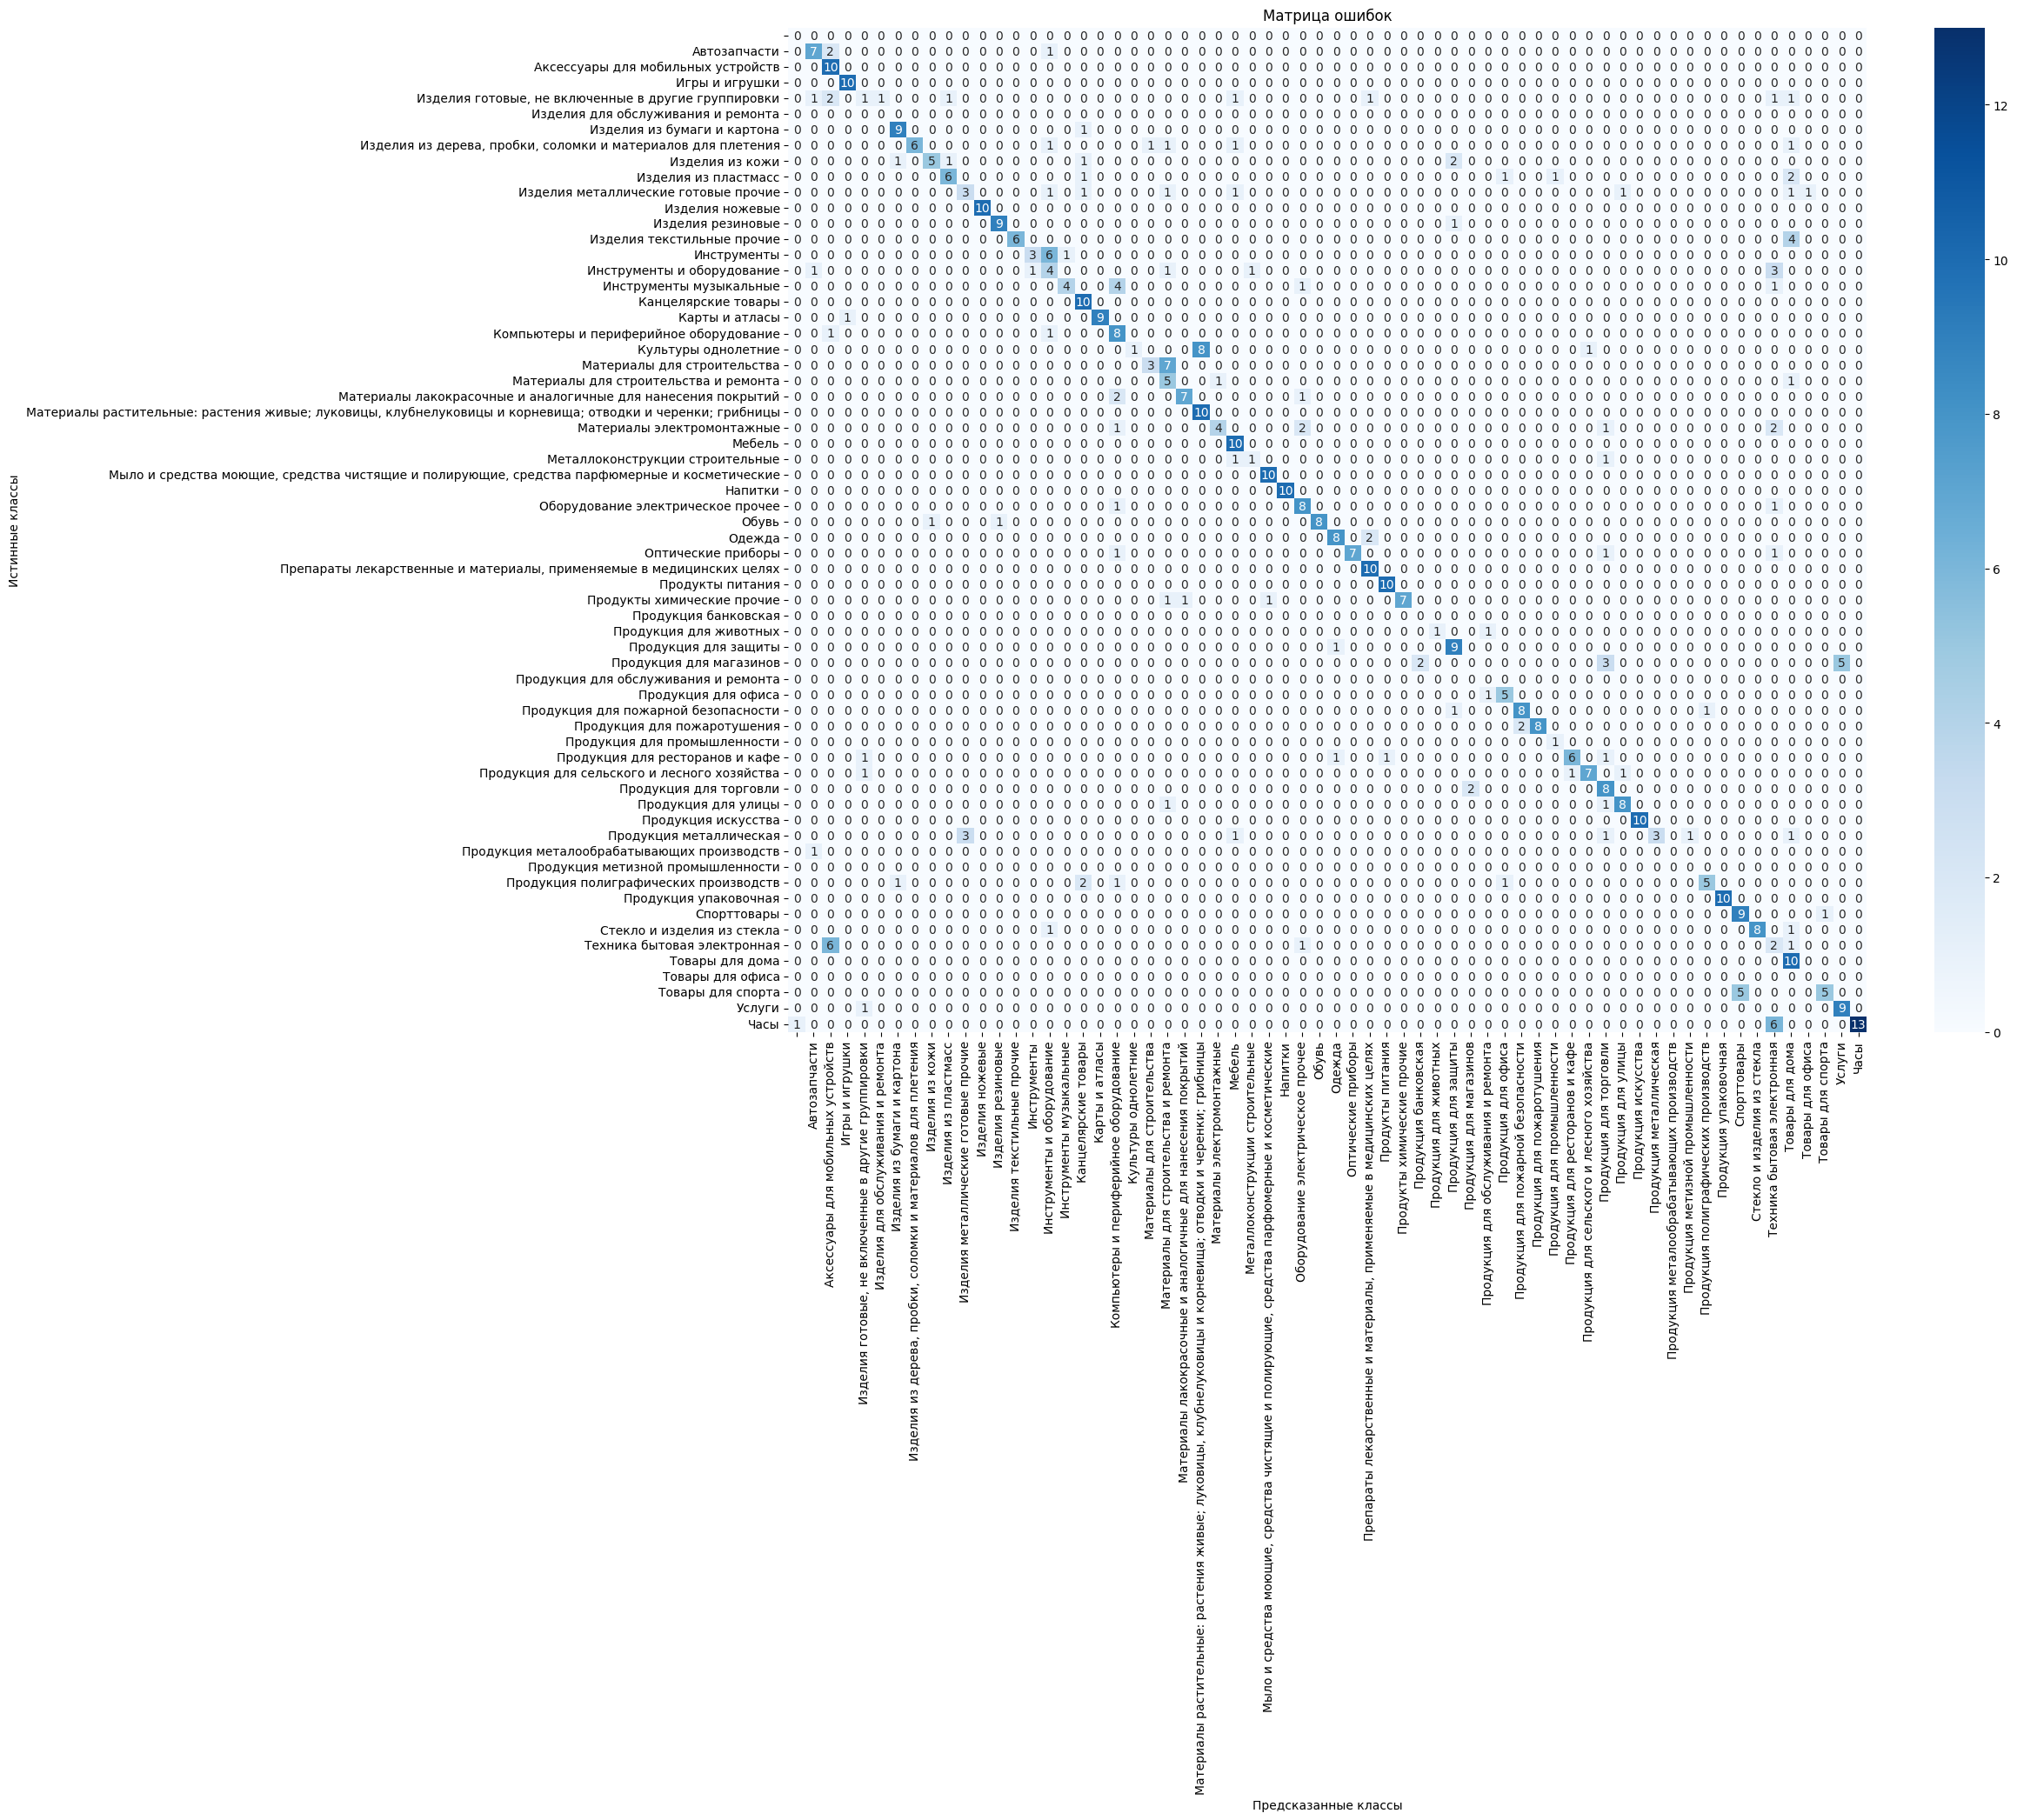

In [44]:
# Преобразование текстовых лейблов в числовые значения
label_encoder = LabelEncoder()

labels = set(y_true + y_pred)
label_encoder.fit_transform(list(labels))
y_true_encoded = label_encoder.transform(y_true)
y_pred_encoded = label_encoder.transform(y_pred)

cm = confusion_matrix(y_true_encoded, y_pred_encoded)

# Получение уникальных названий классов
class_names = label_encoder.classes_

print(f"Accuracy: {accuracy_score(y_true_encoded, y_pred_encoded):.2f}")

# Визуализация матрицы ошибок с названиями категорий
plt.figure(figsize=(20, 15))  # Устанавливаем размер графика
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Предсказанные классы")
plt.ylabel("Истинные классы")
plt.title("Матрица ошибок")
plt.show()

## Подход 3

Подходящие категории + Определение категории

### Первый этап

Подбор подходящих категорий

In [69]:
class ListCategoriesResponse(BaseModel):
    categories: List[str] = Field(..., description="Список подходящих категорий")

parser = PydanticOutputParser(pydantic_object=ListCategoriesResponse)

SYSTEM_PROMPT = """
Ты являешься экспертом по категориям товаров.
Вот список категорий: 
{categories}
Определи, к каким из перечисленных категорий относится этот товар.
Формат ответа: {format_instructions}
Если товар не подходит ни к одной категории, верни пустой массив.
""".split()

USER_PROMPT = """
Товар: {problem_title}
"""

prompt = create_model_prompts(SYSTEM_PROMPT, USER_PROMPT)

In [70]:
batch = [{
    "categories": categories_txt,
    "problem_title": product["title"],
    "problem_categories": product["categories"],
    "format_instructions": parser.get_format_instructions()
} for product in metrics_data]
chain = prompt | llm

first_stage_results = chain.batch(batch)
first_stage_parsed = parser.batch(first_stage_results)

### Второй этап

Определение категории

In [ ]:
class ClassifyResponse(BaseModel):
    category: str = Field(..., description="""Ответ в формате: КАТЕГОРИЯ""")

parser = PydanticOutputParser(pydantic_object=ClassifyResponse)

SYSTEM_PROMPT = """
Ты — эксперт в классификации товаров. Твоя задача — определить категорию товара на основе его названия и вложенных категорий. Используй следующие категории:

{categories}

Правила классификации:  
- Внимательно анализируй название товара.  
- Если название явно указывает на категорию, выбери соответствующую.  
- Если категория не очевидна, выбери наиболее подходящую из предложенных.
- Если в названии товарной позиции описывается действие, то это должна быть категория "Услуги"
- ПО считается услугой

Правила для формирования ответа:
1. **Рассуждение должно быть текстовым.**  
   - Рассуждения должны быть представлены в виде сплошного текста. Блоки кода в ходе рассуждения запрещены.
   - Все логические шаги, анализы и выводы должны быть изложены четко и последовательно.
2. **Финальный ответ должен быть представлен в виде JSON-объекта, заключённого в один блок кода.**  
   - Финальный ответ должен быть корректным JSON-объектом, который заключается в один блок кода (используя три обратных апострофа ```).
   - Внутри JSON-объекта не должно быть дополнительных объяснений или текстовых комментариев.
3. **Фраза "Окончательный ответ" должна предварять блок кода с JSON-объектом.**  
   - Перед блоком кода с JSON-объектом должна быть написана фраза **"Окончательный ответ:"** (без кавычек в самой фразе).  
   - Между фразой и блоком кода не должно быть пустых строк.

Формат ответа должен соответствовать этому: {format_instructions}
""".strip()

USER_PROMPT = """
Товарная позиция: {problem_title}
""".strip()

# Вложенные категории: {problem_categories}
prompt = create_model_prompts(SYSTEM_PROMPT, USER_PROMPT)

In [72]:
def get_categories(categories_array) -> str:
    return "\n".join([f"{i}. {category_name}" for i, category_name in enumerate(categories_array, start=1)])

batch = [{
    "categories": get_categories(res.categories),
    "problem_title": product["title"],
    "problem_categories": product["categories"],
    "format_instructions": parser.get_format_instructions()
} for product, res in zip(metrics_data, first_stage_parsed)]

chain = prompt | llm

results = chain.batch(batch)

In [73]:
y_pred = [get_answer(item.content, "Окончательный ответ:", parser)  for item in results]

Accuracy: 0.62


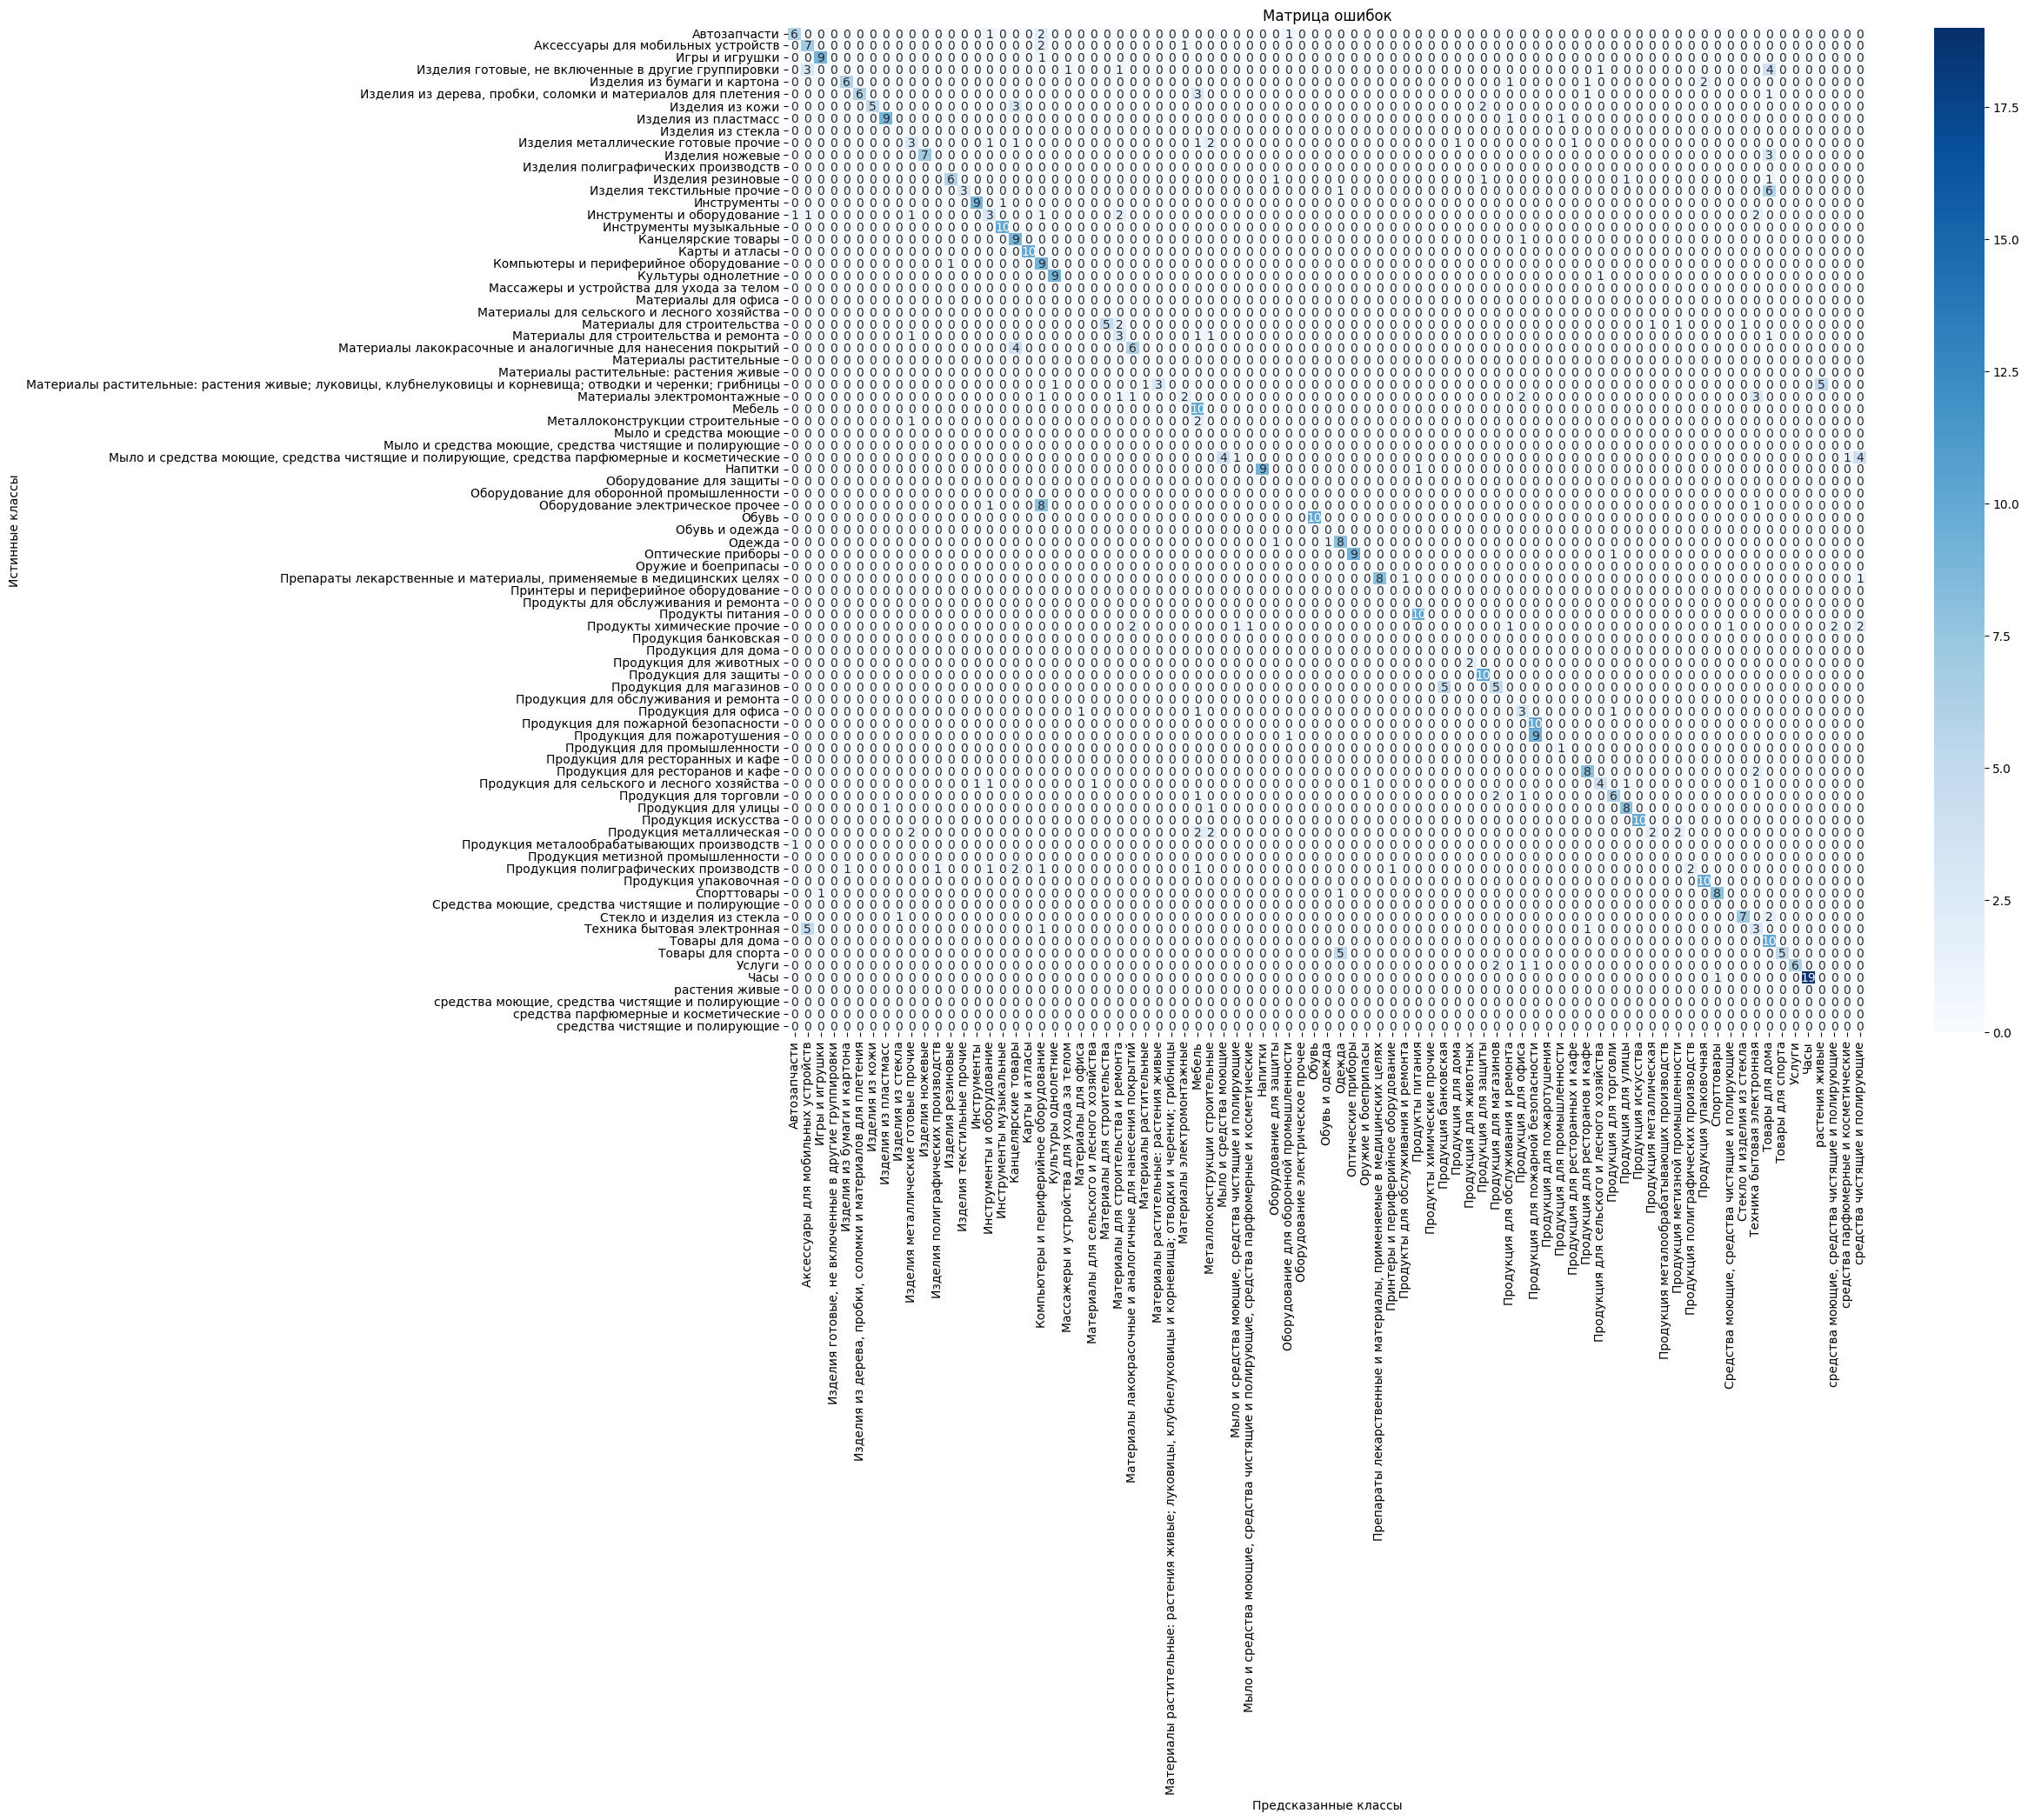

In [74]:
# Преобразование текстовых лейблов в числовые значения
label_encoder = LabelEncoder()

labels = set(y_true + y_pred)
label_encoder.fit_transform(list(labels))
y_true_encoded = label_encoder.transform(y_true)
y_pred_encoded = label_encoder.transform(y_pred)

cm = confusion_matrix(y_true_encoded, y_pred_encoded)

# Получение уникальных названий классов
class_names = label_encoder.classes_

print(f"Accuracy: {accuracy_score(y_true_encoded, y_pred_encoded):.2f}")

# Визуализация матрицы ошибок с названиями категорий
plt.figure(figsize=(20, 15))  # Устанавливаем размер графика
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Предсказанные классы")
plt.ylabel("Истинные классы")
plt.title("Матрица ошибок")
plt.show()

## Подход 4

### Первый этап

In [77]:
SYSTEM_PROMPT = """
Ты эксперт в определении категорий товаров.
Определи, принадлежит ли следующая категория {category_name} товарной позиции.
Отвечай только "да" или "нет".
""".strip()

USER_PROMPT = """
Товарная позиция: {problem_title}
"""

prompt = create_model_prompts(SYSTEM_PROMPT, USER_PROMPT)

In [82]:
batches = [[{
    "category_name": category_name,
    "problem_title": product["title"]       
} for category_name in categories_array] 
for product in metrics_data]

In [84]:
chain = prompt | llm

first_stage_parsed = []

for batch in batches:
    first_stage_results = chain.batch(batch)
    first_stage_parsed.append([categories_array[i] for i, item in enumerate(first_stage_results) if item.content == "да"])

### Второй этап

Определение категории

In [86]:
class ClassifyResponse(BaseModel):
    category: str = Field(..., description="""Ответ в формате: КАТЕГОРИЯ""")

parser = PydanticOutputParser(pydantic_object=ClassifyResponse)

SYSTEM_PROMPT = """
Ты — эксперт в классификации товаров. Твоя задача — определить категорию товара на основе его названия и вложенных категорий. Используй следующие категории:

{categories}

Правила классификации:  
- Внимательно анализируй название товара.  
- Если название явно указывает на категорию, выбери соответствующую.  
- Если категория не очевидна, выбери наиболее подходящую из предложенных.
- Если в названии товарной позиции описывается действие, то это должна быть категория "Услуги"
- ПО считается услугой

Правила для формирования ответа:
1. **Рассуждение должно быть текстовым.**  
   - Рассуждения должны быть представлены в виде сплошного текста. Блоки кода в ходе рассуждения запрещены.
   - Все логические шаги, анализы и выводы должны быть изложены четко и последовательно.
2. **Финальный ответ должен быть представлен в виде JSON-объекта, заключённого в один блок кода.**  
   - Финальный ответ должен быть корректным JSON-объектом, который заключается в один блок кода (используя три обратных апострофа ```).
   - Внутри JSON-объекта не должно быть дополнительных объяснений или текстовых комментариев.
3. **Фраза "Окончательный ответ" должна предварять блок кода с JSON-объектом.**  
   - Перед блоком кода с JSON-объектом должна быть написана фраза **"Окончательный ответ:"** (без кавычек в самой фразе).  
   - Между фразой и блоком кода не должно быть пустых строк.

Формат ответа должен соответствовать этому: {format_instructions}
""".strip()

USER_PROMPT = """
Товарная позиция: {problem_title}
""".strip()

# Вложенные категории: {problem_categories}
prompt = create_model_prompts(SYSTEM_PROMPT, USER_PROMPT)

In [88]:
def get_categories(categories_array) -> str:
    return "\n".join([f"{i}. {category_name}" for i, category_name in enumerate(categories_array, start=1)])

batch = [{
    "categories": get_categories(res),
    "problem_title": product["title"],
    "problem_categories": product["categories"],
    "format_instructions": parser.get_format_instructions()
} for product, res in zip(metrics_data, first_stage_parsed)]



In [89]:
chain = prompt | llm

results = chain.batch(batch)

In [90]:
y_pred = [get_answer(item.content, "Окончательный ответ:", parser)  for item in results]

Accuracy: 0.51


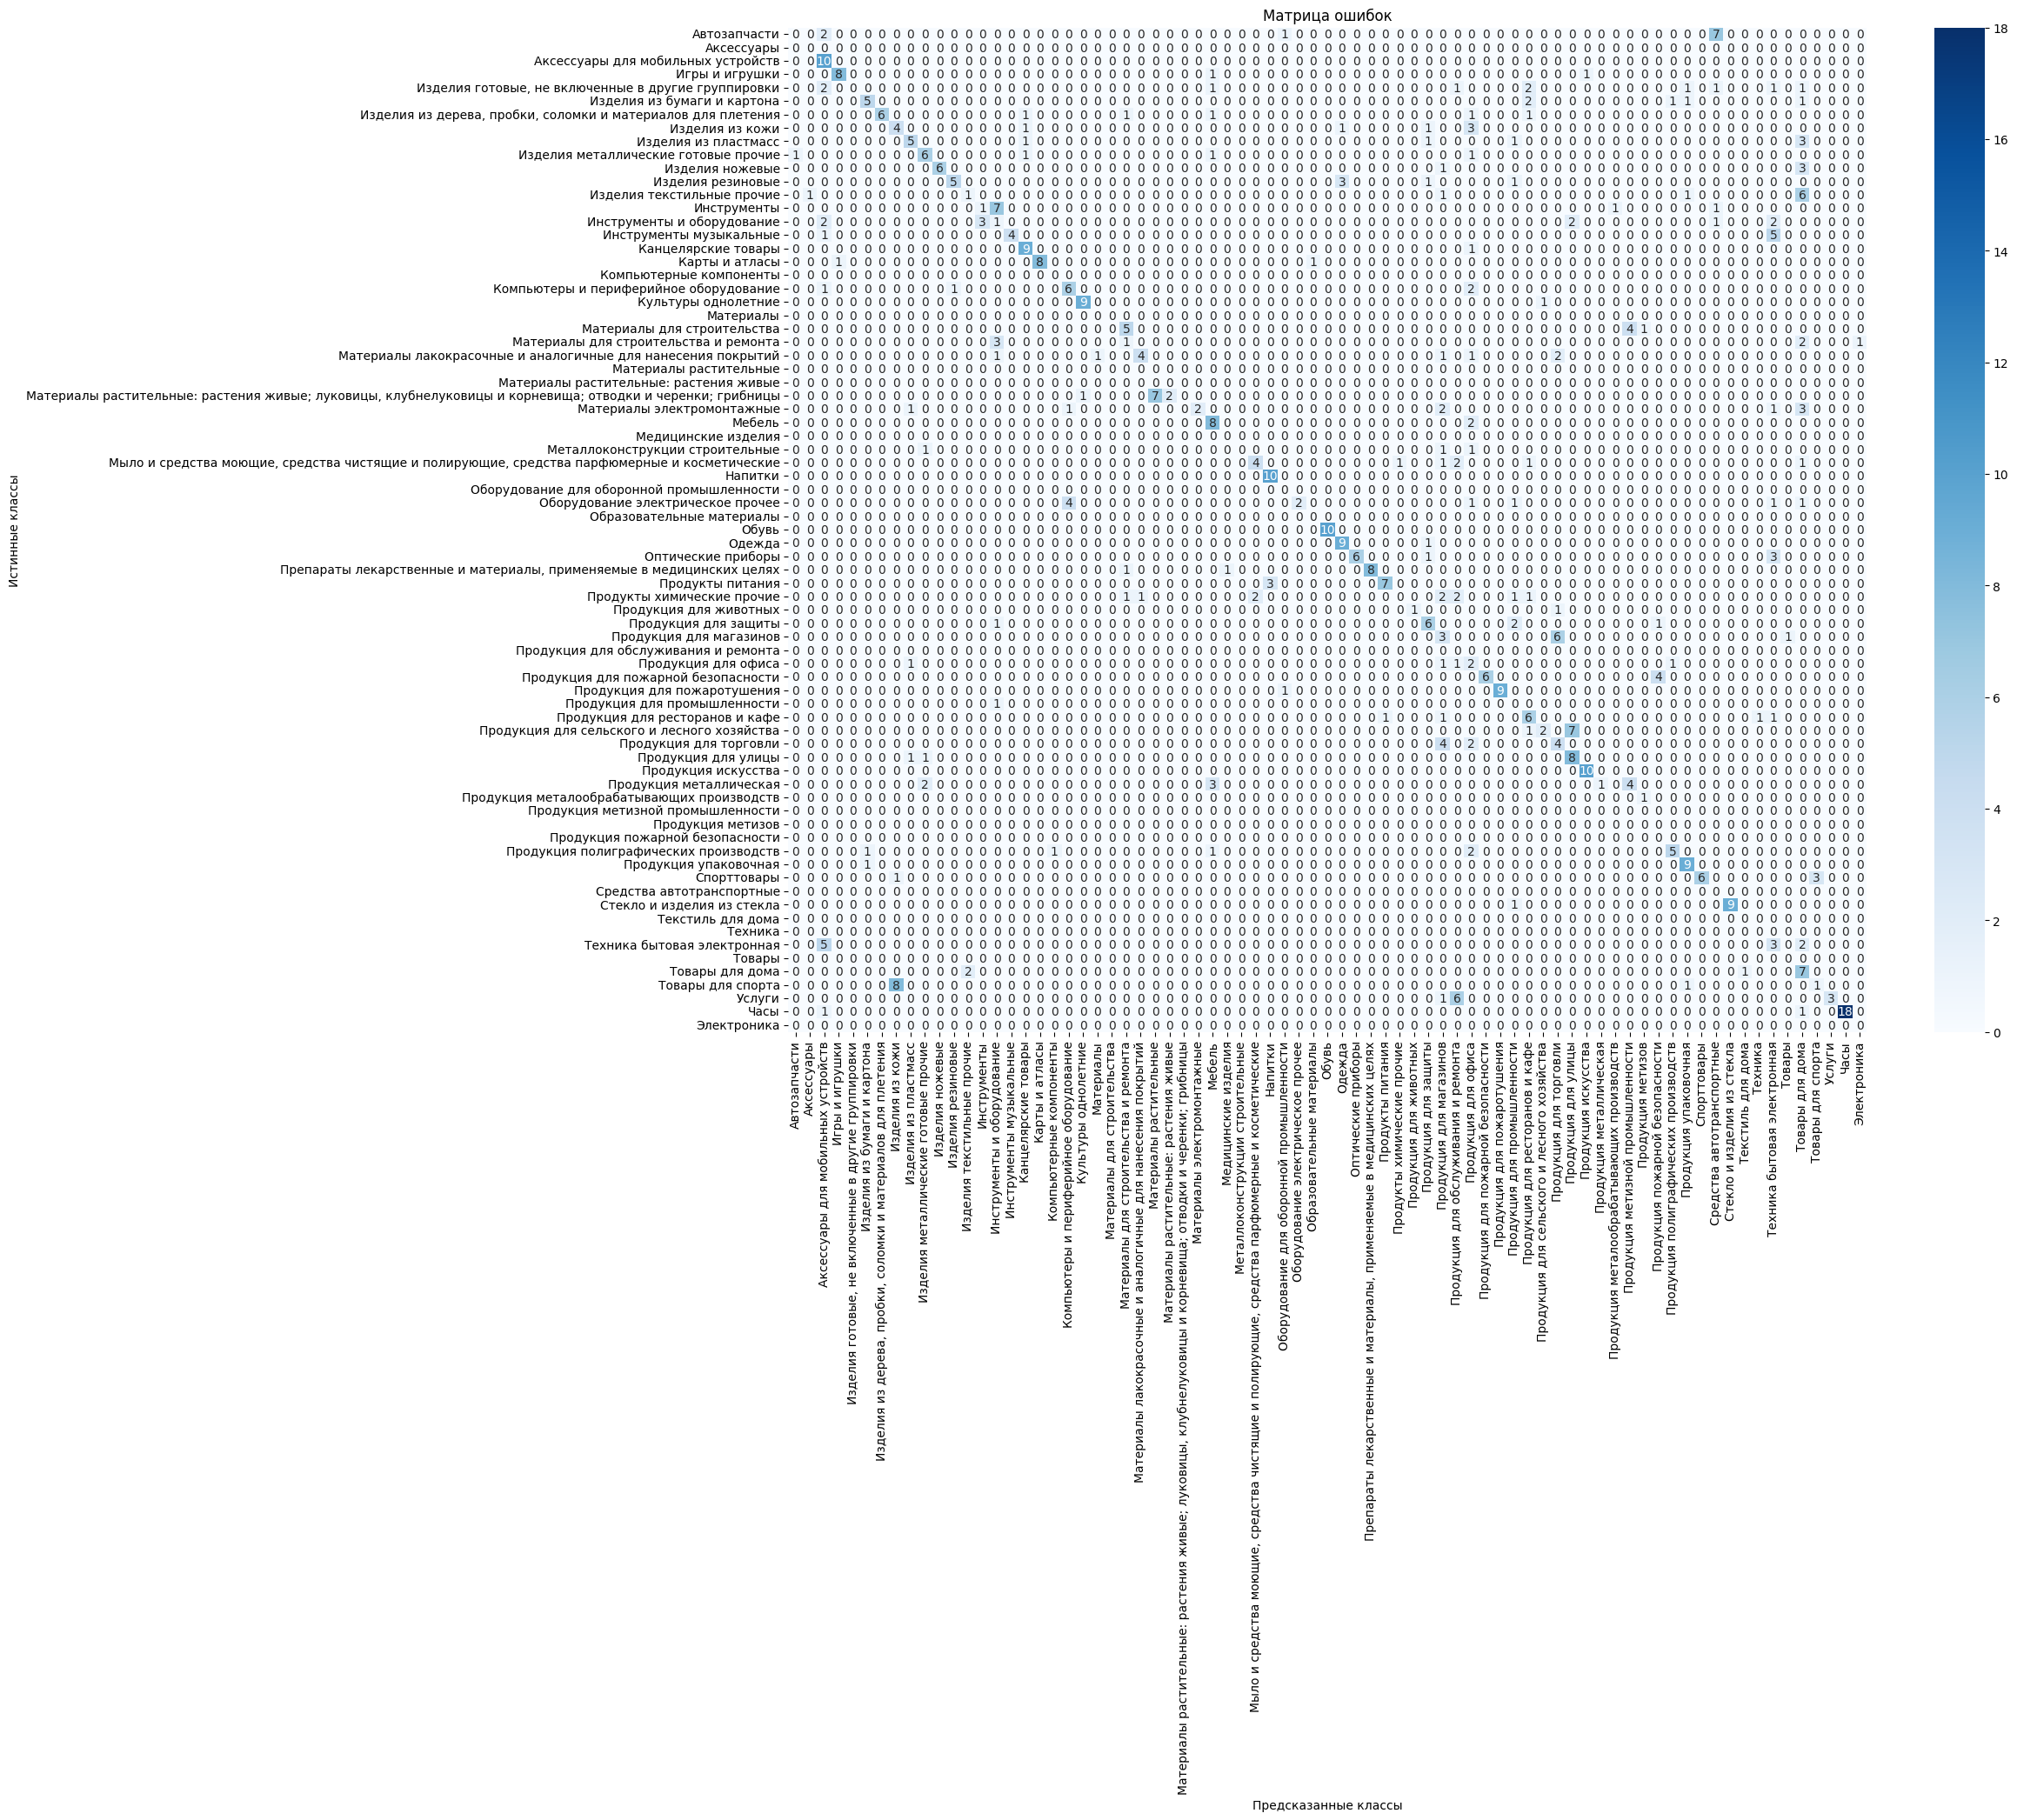

In [91]:
# Преобразование текстовых лейблов в числовые значения
label_encoder = LabelEncoder()

labels = set(y_true + y_pred)
label_encoder.fit_transform(list(labels))
y_true_encoded = label_encoder.transform(y_true)
y_pred_encoded = label_encoder.transform(y_pred)

cm = confusion_matrix(y_true_encoded, y_pred_encoded)

# Получение уникальных названий классов
class_names = label_encoder.classes_

print(f"Accuracy: {accuracy_score(y_true_encoded, y_pred_encoded):.2f}")

# Визуализация матрицы ошибок с названиями категорий
plt.figure(figsize=(20, 15))  # Устанавливаем размер графика
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Предсказанные классы")
plt.ylabel("Истинные классы")
plt.title("Матрица ошибок")
plt.show()

In [97]:
for i, [product, y, predicted_categories] in enumerate(zip(metrics_data, y_pred, first_stage_parsed)):
    print(product["title"])
    print(product["answer"])
    print(y)
    print(predicted_categories)
    print()
    if i == 10:
        break


Подставка для ноутбука/планшета Ugreen LP339 (40291_)
Компьютеры и периферийное оборудование
Компьютеры и периферийное оборудование
['Изделия из пластмасс', 'Компьютеры и периферийное оборудование', 'Продукция для офиса']

Клавиатура проводная ExeGate LY-331 (EX263905RUS)
Компьютеры и периферийное оборудование
Компьютеры и периферийное оборудование
['Аксессуары для мобильных устройств', 'Компьютеры и периферийное оборудование', 'Продукция для офиса', 'Техника бытовая электронная']

Карта памяти 256 ГБ microSDXC Kingston Canvas Select Plus Class 10 UHS-I (SDCS2/256GBSP)
Компьютеры и периферийное оборудование
Аксессуары для мобильных устройств
['Аксессуары для мобильных устройств', 'Компьютеры и периферийное оборудование', 'Продукция для торговли']

Коврик для мыши Cactus Burning Tank (CS-MP-D04M)
Компьютеры и периферийное оборудование
Компьютеры и периферийное оборудование
['Изделия из пластмасс', 'Изделия резиновые', 'Изделия текстильные прочие', 'Компьютеры и периферийное оборудование